Neural Networks study for the datasets.

In [1]:
# Loading the images data.

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import os

from PIL import Image

from sklearn.metrics import roc_curve

# from sklearn.linear_model import LogisticRegression
# from sklearn.linear_model import SGDClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.neural_network import MLPClassifier
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from tensorflow import keras
from keras import layers

import pickle
import time

# Filtering bad images.

In [2]:
# import os

# num_skipped = 0
# for folder_name in ("aves", "mammals"):
#     folder_path = os.path.join("/content/drive/MyDrive/images_resized/", folder_name)
#     for fname in os.listdir(folder_path):
#         fpath = os.path.join(folder_path, fname)
#         try:
#             fobj = open(fpath, "rb")
#             is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
#         finally:
#             fobj.close()

#         if not is_jfif:
#             num_skipped += 1
#             # Delete corrupted image
#             os.remove(fpath)

# print("Deleted %d images" % num_skipped)

In [3]:
AVES_PATH = "/content/drive/MyDrive/images_resized/aves/"
MAMMALS_PATH = "/content/drive/MyDrive/images_resized/mammals/"

In [4]:
# def loadBatch(batchsize, nth_batch, path):
#   imgs = []
#   filesList = os.listdir(path)
#   start = batchsize*nth_batch
#   end =  batchsize*nth_batch + batchsize
#   for i in range(start, end):
#     if(i >= len(filesList)):
#       break
#     f = filesList[i]
#     try:
#       imgdata = list(Image.open(os.path.join(path,f)).convert('RGB').getdata())
#       imgdataReshaped = [x for sets in imgdata for x in sets]
#       imgs.append(imgdataReshaped)
#     except:
#       continue
#       pass
#   return imgs

In [5]:
def show(imgs, titles=[], r= 3, c=3):
  plt.figure(figsize=(7, 7))
  for i, avian in enumerate(imgs):
    plt.subplot(r, c, i+1)
    plt.imshow(np.array(avian).reshape(224,224,3))
    if(len(imgs) != len(titles)):
      plt.title( str(i), fontsize=10)
    else:
      plt.title( str(titles[i]), fontsize=8)
    plt.axis('off')
  plt.show()

# Model explorations. 

## Neural model.

In [6]:
# Input function for defining the dataset
training_size = 3200
batch_size = 100
def input_fn(path):
  # Convert the inputs to a Dataset.
  dataset = tf.data.Dataset.from_tensor_slices(loadBatch(training_size, 0, path))
  return dataset.batch(batch_size)

In [7]:
image_size = (224, 224)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./images_resized",
    validation_split=0.15,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./images_resized/",
    validation_split=0.15,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 7583 files belonging to 2 classes.
Using 6446 files for training.
Found 7583 files belonging to 2 classes.
Using 1137 files for validation.


In [8]:
#train_ds_reshaped = tf.reshape(test_ds, [2,  ])
#iamges_labels = test_ds.take(1)
#print(tf.shape())

In [9]:
class_names = train_ds.class_names
print(class_names)

['aves', 'mammals']


In [10]:
#plt.figure(figsize=(10, 10))

img_dataset = train_ds.take(1)

print(list(img_dataset.as_numpy_iterator())[0][1])

[0 0 1 0 1 0 0 1 0 1 1 1 0 0 1 1 0 0 0 1 1 0 1 1 0 0 0 0 1 1 0 1]


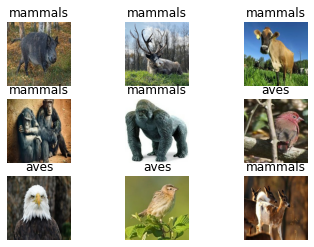

In [11]:

#images, labels = train_ds.take(1)


for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Adding more image daata to increase training efficiency.

In [12]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
    ]
)

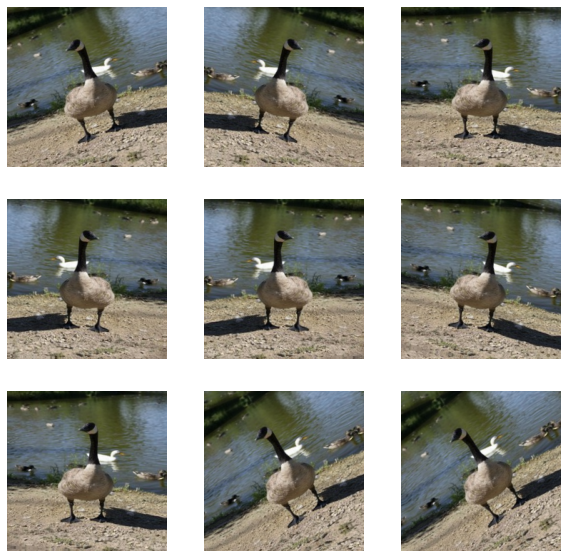

In [13]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [14]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [15]:
def make_model_neural(input_dim, active_mode = 'relu'):
    inputs = keras.Input(shape=input_dim)


    # Image augmentation block
    x = data_augmentation(inputs)

    # pre processing block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Flatten()(x)

    # Training
    x = layers.Dense(720, activation = active_mode)(x)
    x = layers.Dense(450, activation  = active_mode)(x)
    x = layers.Dense(128, activation  = active_mode)(x)

    # Classify
    
    # x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation = "sigmoid")(x)

    return keras.Model(inputs, outputs)

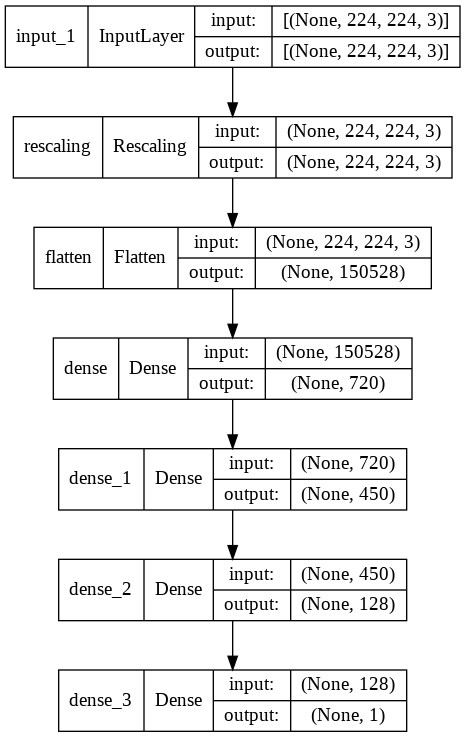

In [10]:
img_size_dim = image_size[0] * image_size[1] * 3
nn_model = make_model_neural(input_dim = image_size + (3,) )
keras.utils.plot_model(nn_model, show_shapes=True)

In [11]:
epochs = 10
print()
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
nn_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

# train_ds_reshaped = train_ds.apply(tf.contrib.data.unbatch())
# val_ds_reshaped   = val_ds.apply(tf.contrib.data.unbatch())


nn_history = nn_model.fit(
   train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds
)


Epoch 1/10
202/202 [==============================] - 154s 733ms/step - loss: 5.2484 - accuracy: 0.5397 - val_loss: 1.2795 - val_accuracy: 0.5075
Epoch 2/10
202/202 [==============================] - 148s 727ms/step - loss: 0.8390 - accuracy: 0.5569 - val_loss: 1.2356 - val_accuracy: 0.5022
Epoch 3/10
202/202 [==============================] - 145s 714ms/step - loss: 0.6934 - accuracy: 0.5906 - val_loss: 0.6366 - val_accuracy: 0.6280
Epoch 4/10
202/202 [==============================] - 146s 718ms/step - loss: 0.6834 - accuracy: 0.5929 - val_loss: 0.6779 - val_accuracy: 0.6209
Epoch 5/10
202/202 [==============================] - 145s 714ms/step - loss: 0.6876 - accuracy: 0.5413 - val_loss: 0.6927 - val_accuracy: 0.5048
Epoch 6/10
202/202 [==============================] - 146s 718ms/step - loss: 0.6906 - accuracy: 0.5129 - val_loss: 0.6917 - val_accuracy: 0.5048
Epoch 7/10
202/202 [==============================] - 145s 711ms/step - loss: 0.6930 - accuracy: 0.5020 - val_loss: 0.6923 

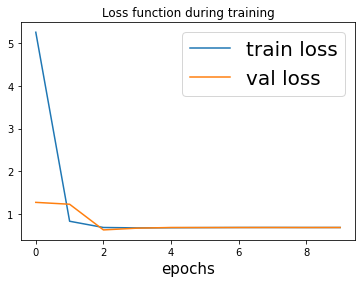

In [14]:
plt.title("Loss Function Neural Network")
plt.plot(nn_history.history['loss'], label='train loss')
plt.plot(nn_history.history['val_loss'], label='val loss')
plt.xlabel('epochs', fontsize=15)
plt.legend(fontsize=20)
plt.show()

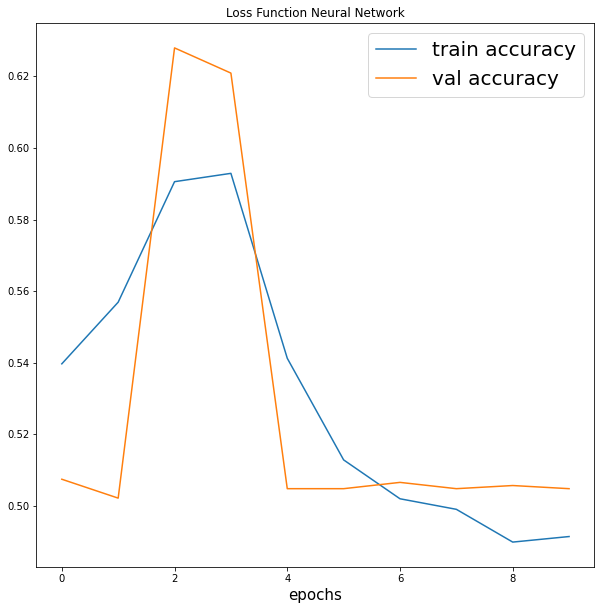

In [16]:
plt.figure(figsize=(10,10))
plt.title("Loss Function Neural Network")
plt.plot(nn_history.history['accuracy'], label='train accuracy')
plt.plot(nn_history.history['val_accuracy'], label='val accuracy')
plt.xlabel('epochs', fontsize=15)
plt.legend(fontsize=20)
plt.show()

# CNN Model on tensorflow


In [11]:
def make_cnn(input_dim, active_mode = 'relu'):
    inputs = keras.Input(shape=input_dim)
   

    # Image augmentation block
    x = data_augmentation(inputs)

    # pre processing block
    x = layers.Rescaling(1.0 / 255)(inputs)


    x = layers.Conv2D(16, 3, padding='same', activation = active_mode)(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(32, 3, padding='same', activation = active_mode)(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, padding='same', activation = active_mode)(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation= active_mode)(x)
    x = layers.Dense(1)(x)

    # Classify
    outputs = layers.Dense(1, activation = "sigmoid")(x)

    return keras.Model(inputs, outputs)


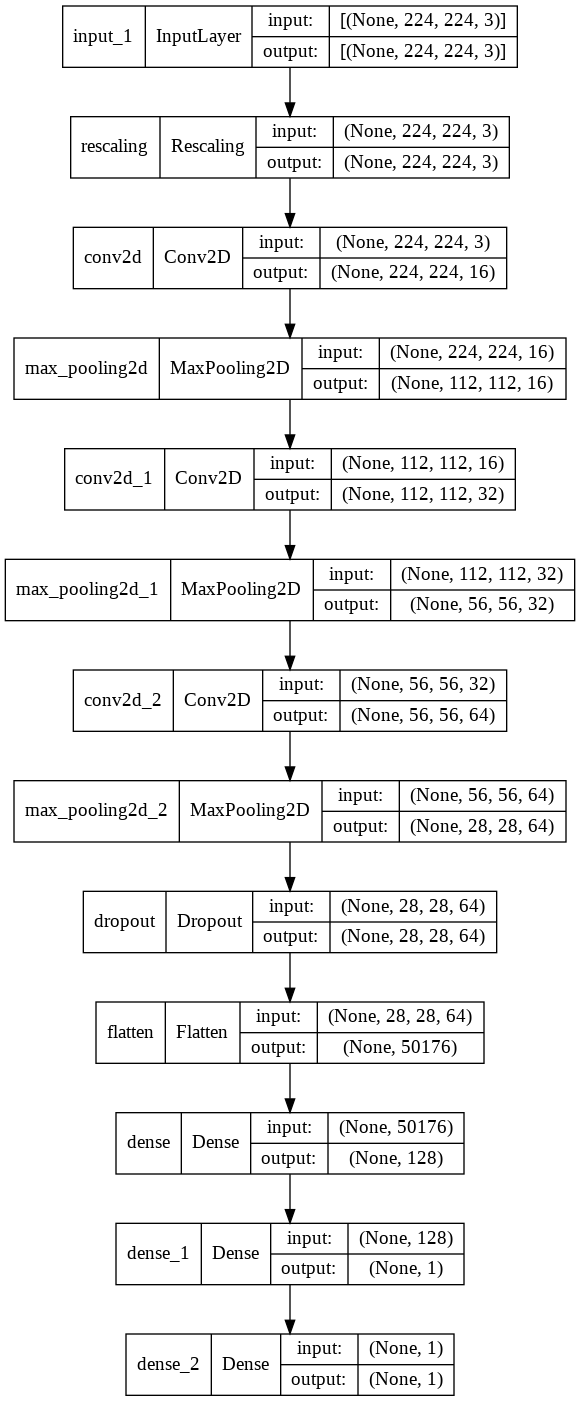

In [12]:
cnn_model = make_cnn(input_dim = image_size + (3,) )
keras.utils.plot_model(cnn_model, show_shapes=True)

In [13]:
epochs = 10
print()
callbacks_cnn = [
    keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/ccnn_save_at_{epoch}.h5"),
]
cnn_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy", "mse"],
)

cnn_history = cnn_model.fit(
   train_ds, epochs=epochs, callbacks=callbacks_cnn, validation_data=val_ds
)


Epoch 1/10
202/202 [==============================] - 323s 2s/step - loss: 0.6463 - accuracy: 0.6086 - mse: 0.2278 - val_loss: 0.5782 - val_accuracy: 0.6992 - val_mse: 0.1967
Epoch 2/10
202/202 [==============================] - 317s 2s/step - loss: 0.5213 - accuracy: 0.7353 - mse: 0.1746 - val_loss: 0.4269 - val_accuracy: 0.8162 - val_mse: 0.1367
Epoch 3/10
202/202 [==============================] - 320s 2s/step - loss: 0.4050 - accuracy: 0.8225 - mse: 0.1279 - val_loss: 0.4648 - val_accuracy: 0.7951 - val_mse: 0.1473
Epoch 4/10
202/202 [==============================] - 312s 2s/step - loss: 0.3412 - accuracy: 0.8532 - mse: 0.1049 - val_loss: 0.3391 - val_accuracy: 0.8549 - val_mse: 0.1054
Epoch 5/10
202/202 [==============================] - 309s 2s/step - loss: 0.2787 - accuracy: 0.8854 - mse: 0.0843 - val_loss: 0.3747 - val_accuracy: 0.8487 - val_mse: 0.1099
Epoch 6/10
202/202 [==============================] - 311s 2s/step - loss: 0.2178 - accuracy: 0.9116 - mse: 0.0644 - val_los

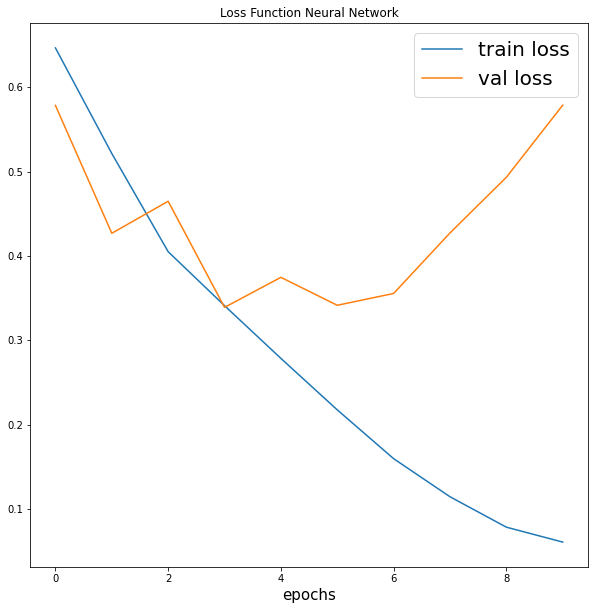

In [21]:
plt.figure(figsize=(10,10))
plt.title("Loss Function Neural Network")
plt.plot(cnn_history.history['loss'], label='train loss')
plt.plot(cnn_history.history['val_loss'], label='val loss')
plt.xlabel('epochs', fontsize=15)
plt.legend(fontsize=20)
plt.show()

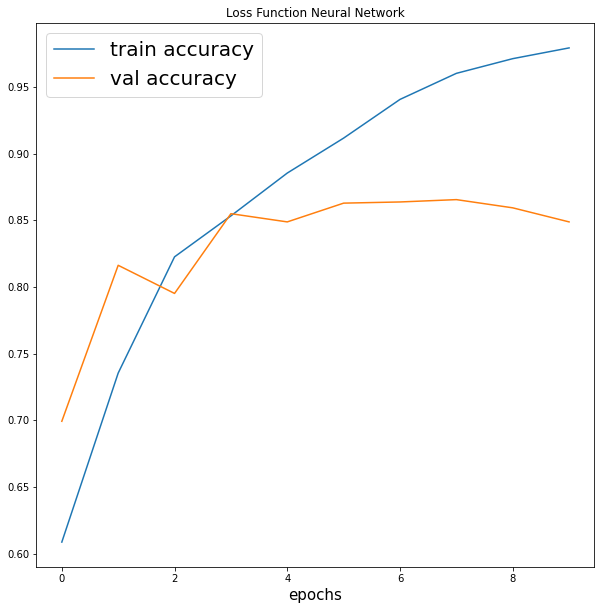

In [17]:
plt.figure(figsize=(10,10))
plt.title("Loss Function Neural Network")
plt.plot(cnn_history.history['accuracy'], label='train accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='val accuracy')
plt.xlabel('epochs', fontsize=15)
plt.legend(fontsize=20)
plt.show()

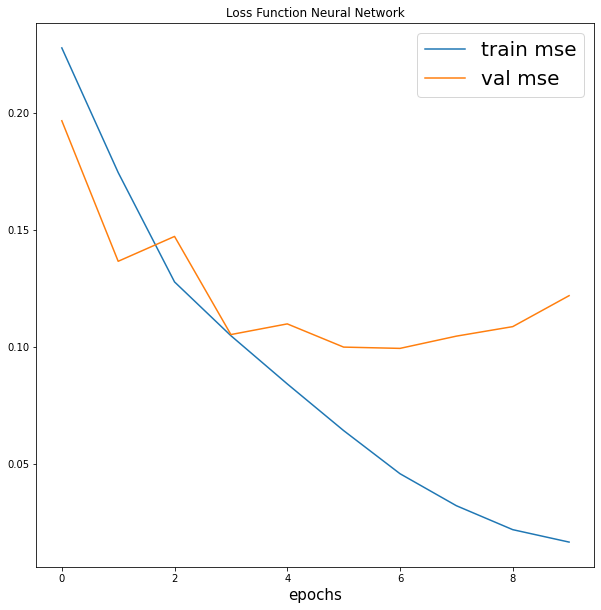

In [22]:
plt.figure(figsize=(10,10))
plt.title("Loss Function Neural Network")
plt.plot(cnn_history.history['mse'], label='train mse')
plt.plot(cnn_history.history['val_mse'], label='val mse')
plt.xlabel('epochs', fontsize=15)
plt.legend(fontsize=20)
plt.show()

hell


In [20]:
filename = "/content/drive/MyDrive/cnn_neuralmodel.sav"
pickle.dump(cnn_model, open(filename, 'wb'))

INFO:tensorflow:Assets written to: ram://ef16b139-712f-4a65-a19c-65b9f4f482f7/assets


# Rasnet50 model

In [34]:
def make_resnet50(input_dim, active_mode = 'relu'):
    inputs = keras.Input(shape=input_dim)
   

    # Image augmentation block
    x = data_augmentation(inputs)

    # pre processing block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = tf.keras.applications.resnet50.preprocess_input(x)
    x = tf.keras.applications.ResNet50(include_top=False, weights='imagenet')(x)
    x = tf.keras.layers.Flatten()(x)
    outputs = tf.keras.layers.Dense(1, activation='softmax')(x)
    # Classify
    #outputs = layers.Dense(1, activation = "sigmoid")(x)

    return keras.Model(inputs, outputs)


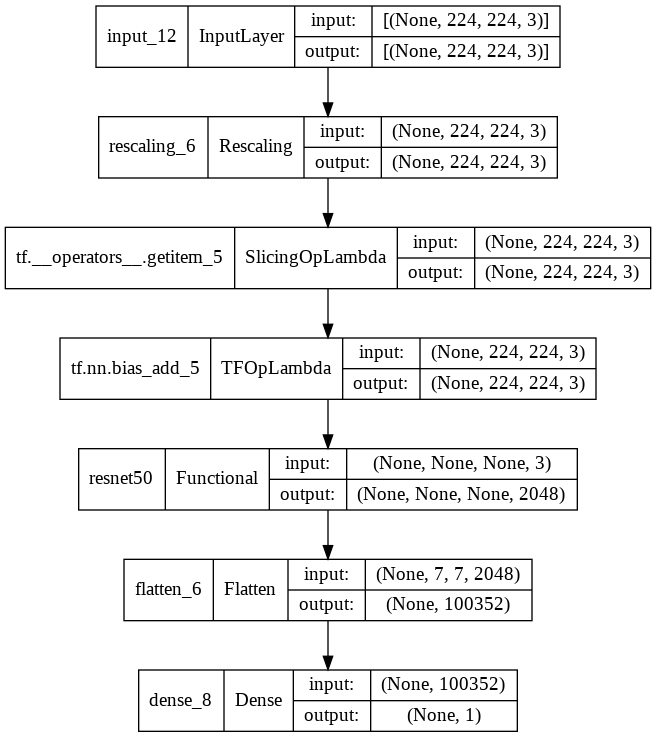

In [37]:
resnet_mode = make_resnet50(input_dim = image_size + (3,))

resnet_mode.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc', "accuracy", "mse"], optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))


keras.utils.plot_model(resnet_mode, show_shapes=True)

In [38]:
callbacks_resnet = [
    keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/resnet_save_at_{epoch}.h5"),
]

resnet_history = resnet_mode.fit(
   train_ds, epochs=epochs, callbacks=callbacks_resnet, validation_data=val_ds
)

Epoch 1/10
  3/202 [..............................] - ETA: 1:12:45 - loss: 1.0351 - acc: 0.5104 - accuracy: 0.5104 - mse: 0.4896

KeyboardInterrupt: ignored

# Semi Resnet 


In [20]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 720]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

In [21]:
plt.figure(figsize=(5,5))
ris_model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(ris_model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


<Figure size 360x360 with 0 Axes>

In [22]:
epochs = 10
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]

ris_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy","mse","acc"],
)

ris_history = ris_model.fit(
   train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds
)

Epoch 1/10
202/202 [==============================] - 85s 410ms/step - loss: 0.5625 - accuracy: 0.7344 - mse: 0.1834 - acc: 0.7344 - val_loss: 1.2295 - val_accuracy: 0.4969 - val_mse: 0.4157 - val_acc: 0.4969
Epoch 2/10
202/202 [==============================] - 83s 411ms/step - loss: 0.4399 - accuracy: 0.7944 - mse: 0.1414 - acc: 0.7944 - val_loss: 1.0244 - val_accuracy: 0.4969 - val_mse: 0.3674 - val_acc: 0.4969
Epoch 3/10
202/202 [==============================] - 85s 420ms/step - loss: 0.3783 - accuracy: 0.8354 - mse: 0.1179 - acc: 0.8354 - val_loss: 0.8987 - val_accuracy: 0.6570 - val_mse: 0.2603 - val_acc: 0.6570
Epoch 4/10
202/202 [==============================] - 87s 430ms/step - loss: 0.3440 - accuracy: 0.8523 - mse: 0.1063 - acc: 0.8523 - val_loss: 0.4342 - val_accuracy: 0.8012 - val_mse: 0.1397 - val_acc: 0.8012
Epoch 5/10
202/202 [==============================] - 88s 436ms/step - loss: 0.3265 - accuracy: 0.8593 - mse: 0.0997 - acc: 0.8593 - val_loss: 0.7610 - val_accuracy

In [ ]:
# tf.keras.models.save_model(
#     ris_model, "/content/MyDrive/models/risidual_model.mdl", overwrite=True, include_optimizer=True, save_format=None,
#     signatures=None, options=None, save_traces=True
# )

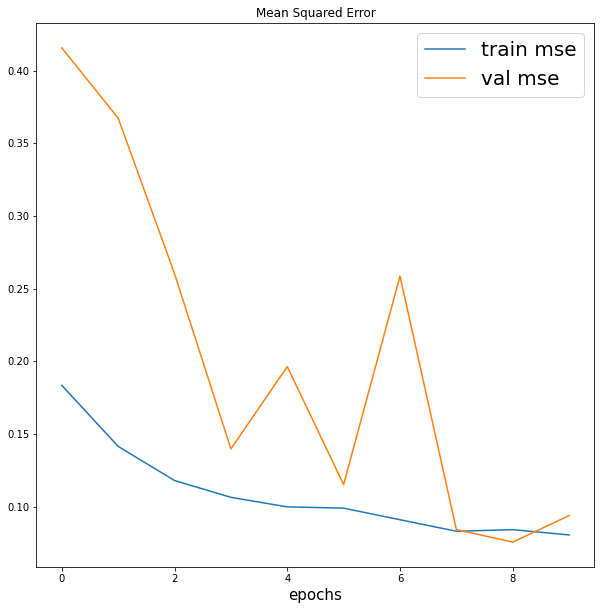

In [23]:
plt.figure(figsize=(10,10))
plt.title("Mean Squared Error")
plt.plot(ris_history.history['mse'], label='train mse')
plt.plot(ris_history.history['val_mse'], label='val mse')
plt.xlabel('epochs', fontsize=15)
plt.legend(fontsize=20)
plt.show()

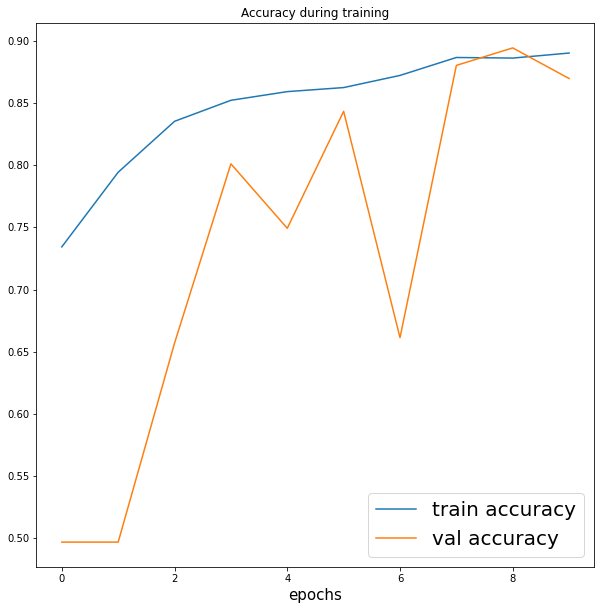

In [24]:
plt.figure(figsize=(10,10))
plt.title("Accuracy during training")
plt.plot(ris_history.history['accuracy'], label='train accuracy')
plt.plot(ris_history.history['val_accuracy'], label='val accuracy')
plt.xlabel('epochs', fontsize=15)
plt.legend(fontsize=20)
plt.show()

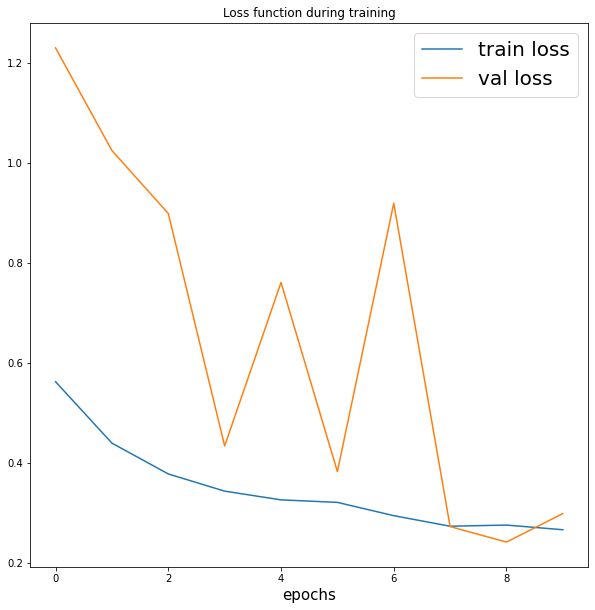

In [25]:
plt.figure(figsize=(10,10))
plt.title("Loss function during training")
plt.plot(ris_history.history['loss'], label='train loss')
plt.plot(ris_history.history['val_loss'], label='val loss')
plt.xlabel('epochs', fontsize=15)
plt.legend(fontsize=20)
plt.show()

In [ ]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

# Resnet50

In [15]:
def make_resnet50(input_dim, active_mode = 'relu'):
    inputs = keras.Input(shape=input_dim)
   

    # Image augmentation block
    x = data_augmentation(inputs)

    # pre processing block
    x = layers.Rescaling(1.0 / 255)(inputs)
    
    # Resnet50
    x = tf.keras.applications.resnet50.preprocess_input(x)
    x = tf.keras.applications.ResNet50(include_top=False, weights='imagenet')(x)
    
    # pre processing block
    x = tf.keras.layers.Flatten()(x)

    # Reducing layers
    x = layers.Dense(256, activation  = active_mode)(x)
    #x = layers.Dense(128, activation  = active_mode)(x)
    
    
    outputs = tf.keras.layers.Dense(1, activation='softmax')(x)
    # Classify
    #outputs = layers.Dense(1, activation = "sigmoid")(x)

    return keras.Model(inputs, outputs)


In [16]:
resnet_mode = make_resnet50(input_dim = image_size + (3,))


resnet_mode.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc', "accuracy", "mse"], optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))


keras.utils.plot_model(resnet_mode, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [17]:
epochs = 10
resnet_history = resnet_mode.fit(
   train_ds, epochs=epochs, validation_data=val_ds
)

Epoch 1/10
202/202 [==============================] - 90s 400ms/step - loss: 0.2545 - acc: 0.4992 - accuracy: 0.4992 - mse: 0.5008 - val_loss: 0.8168 - val_acc: 0.4969 - val_accuracy: 0.4969 - val_mse: 0.5031
Epoch 2/10
202/202 [==============================] - 79s 391ms/step - loss: 0.0634 - acc: 0.4992 - accuracy: 0.4992 - mse: 0.5008 - val_loss: 3.6432 - val_acc: 0.4969 - val_accuracy: 0.4969 - val_mse: 0.5031
Epoch 3/10
202/202 [==============================] - 79s 393ms/step - loss: 0.0594 - acc: 0.4992 - accuracy: 0.4992 - mse: 0.5008 - val_loss: 1.8069 - val_acc: 0.4969 - val_accuracy: 0.4969 - val_mse: 0.5031
Epoch 4/10
202/202 [==============================] - 80s 395ms/step - loss: 0.0298 - acc: 0.4992 - accuracy: 0.4992 - mse: 0.5008 - val_loss: 3.4358 - val_acc: 0.4969 - val_accuracy: 0.4969 - val_mse: 0.5031
Epoch 5/10
202/202 [==============================] - 81s 400ms/step - loss: 0.0356 - acc: 0.4992 - accuracy: 0.4992 - mse: 0.5008 - val_loss: 5.5568 - val_acc: 0.4

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(10,10))
plt.title("Mean Squared Error")
plt.plot(resnet_history.history['mse'], label='train mse')
plt.plot(resnet_history.history['val_mse'], label='val mse')
plt.xlabel('epochs', fontsize=15)
plt.legend(fontsize=20)
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
plt.title("Accuracy during training")
plt.plot(resnet_history.history['accuracy'], label='train accuracy')
plt.plot(resnet_history.history['val_accuracy'], label='val accuracy')
plt.xlabel('epochs', fontsize=15)
plt.legend(fontsize=20)
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
plt.title("Loss function during training")
plt.plot(resnet_history.history['loss'], label='train loss')
plt.plot(resnet_history.history['val_loss'], label='val loss')
plt.xlabel('epochs', fontsize=15)
plt.legend(fontsize=20)
plt.show()